In [1]:
import sklearn.model_selection
import sklearn.linear_model
import sklearn.datasets
import sklearn.ensemble
import sklearn.metrics
import sklearn.tree
import sklearn.svm
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib
import numpy as np

If you aggregate the predictions of a group of predictors, you will often get better predictions than with the best individual predictor. A group of predictors is called an `ensemble`; thus, this technique is called `Ensemble Learning`, and an Ensemble Learning algorithm is called an `Ensemble method`.

For example, you can train a group of Decision Tree classifiers, each on a different random subset of the training set. To make predictions, you just obtain the predictions of all individual trees, then predict the class that gets the most votes. Such an ensemble of Decision Trees is called a `Random Forest`, and despite its simplicity, this is one of the most powerful Machine Learning algorithms available today.

Moreover, as we discussed in `Chapter 2`, you will often use Ensemble methods near the end of a project, once you have already built a few good predictors, to combine them into an even better predictor. In fact, the winning solutions in Machine Learning competitions often involve several Ensemble methods (most famously in the Netflix Prize competition).

In this chapter we will discuss the most popular Ensemble methods, including `bagging`, `boosting`, `stacking`, and a few others. We will also explore `Random Forests`.

## 7.1 Voting Classifiers
Suppose you have trained a few classifiers, each one achieving about 80% accuracy. You may have a `Logistic Regression` classifier, an `SVM` classifier, a `Random Forest` classifier, a `K-Nearest Neighbors` classifier, and perhaps a few more (see `Figure 7-1`):
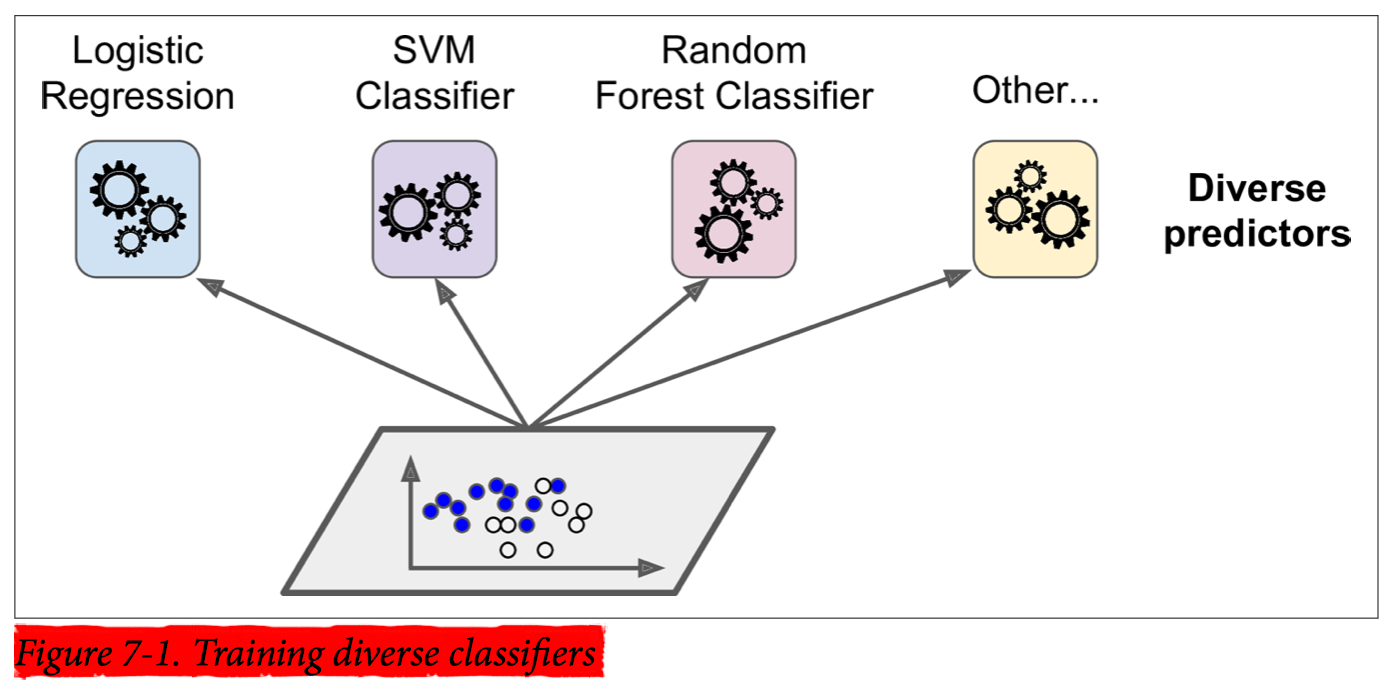

A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier is called a `hard voting classifier` (see Figure `7-2`):
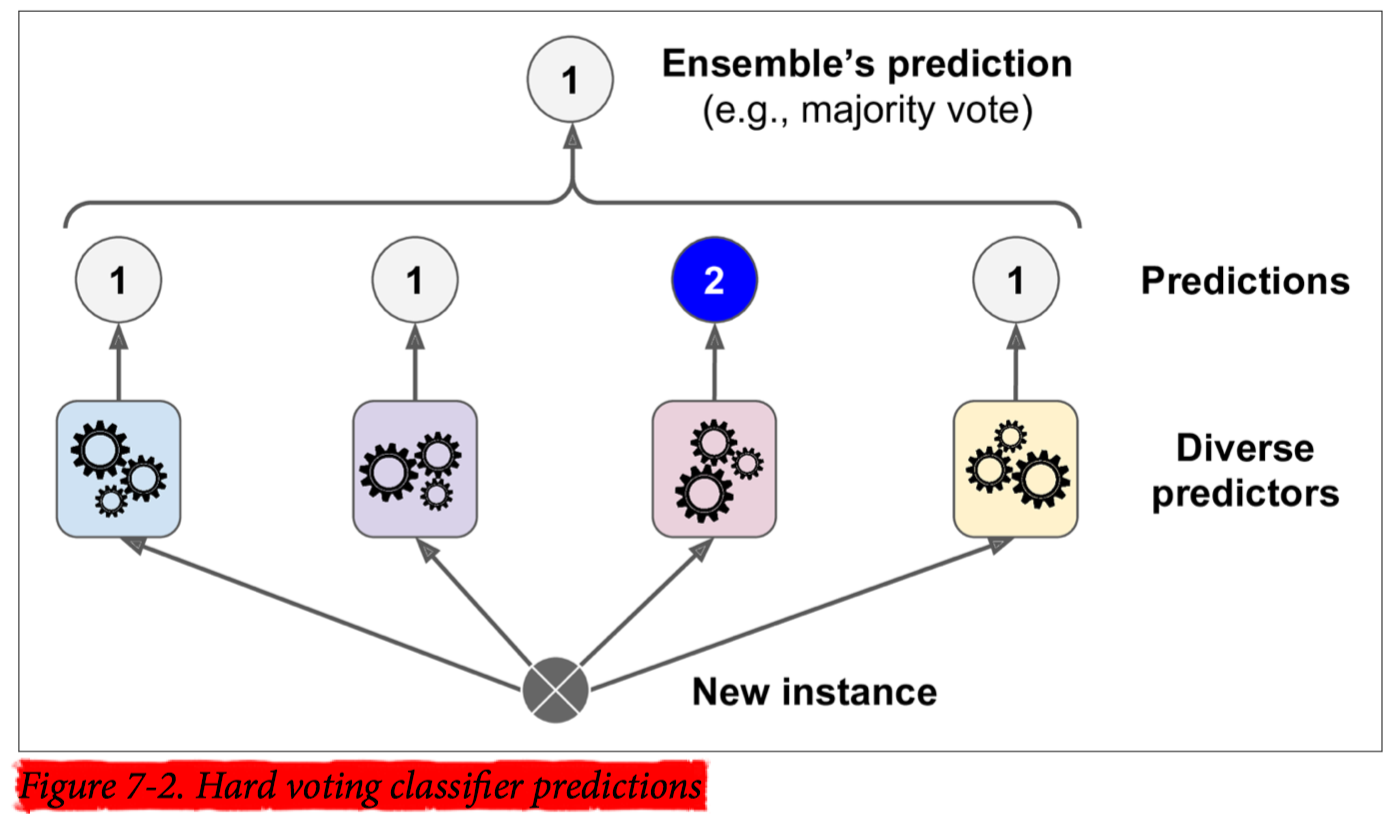

Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the best classifier in the ensemble. In fact, even if each classifier is a weak learner (meaning it does only slightly better than random guessing), the ensemble can still be a strong learner (achieving high accuracy), provided there are a sufficient number of weak learners and they are sufficiently diverse.

How is this possible? The following analogy can help shed some light on this mystery. Suppose you have a slightly biased coin that has a 51% chance of coming up heads, and 49% chance of coming up tails. If you toss it 1,000 times, you will generally get more or less 510 heads and 490 tails, and hence a majority of heads. If you do the math, you will find that the probability of obtaining a majority of heads after 1,000 tosses is close to 75%. The more you toss the coin, the higher the probability (e.g., with 10,000 tosses, the probability climbs over 97%). This is due to `the law of large numbers`: as you keep tossing the coin, the ratio of heads gets closer and closer to the probability of heads (51%). `Figure 7-3` shows 10 series of biased coin tosses. You can see that as the number of tosses increases, the ratio of heads approaches 51%. Eventually all 10 series end up so close to 51% that they are consistently above 50%:
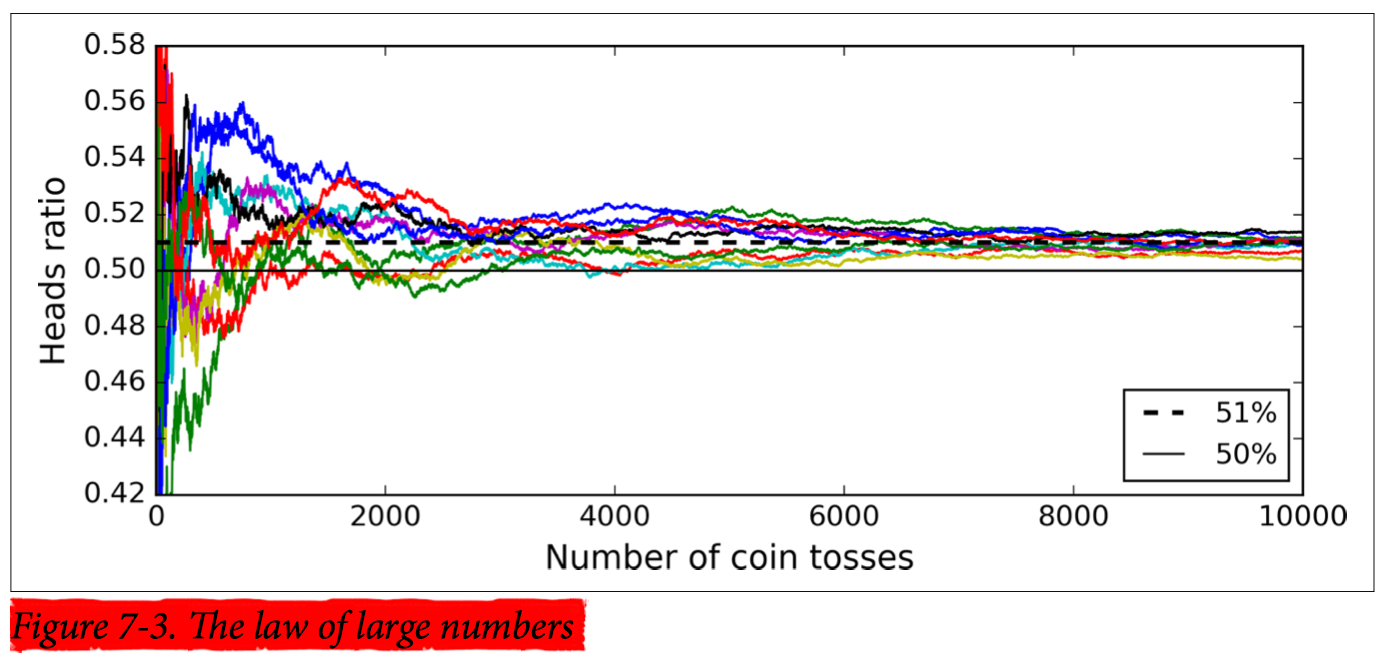

Similarly, suppose you build an ensemble containing 1,000 classifiers that are individually correct only 51% of the time (barely better than random guessing). If you predict the majority voted class, you can hope for up to 75% accuracy! However, this is only true if all classifiers are perfectly independent, making uncorrelated errors, which is clearly not the case since they are trained on the same data. They are likely to make the same types of errors, so there will be many majority votes for the wrong class, reducing the ensemble’s accuracy.

> Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy.

The following code creates and trains a voting classifier in Scikit-Learn, composed of three diverse classifiers:

In [2]:
X, y = sklearn.datasets.make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=42)

log_clf = sklearn.linear_model.LogisticRegression(random_state=42) 
rnd_clf = sklearn.ensemble.RandomForestClassifier(random_state=42) 
svm_clf = sklearn.svm.SVC(random_state=42)

voting_clf = sklearn.ensemble.VotingClassifier( 
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], 
    voting='hard') 
voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, sklearn.metrics.accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


The voting classifier slightly outperforms all the individual classifiers.

If all classifiers are able to estimate class probabilities (i.e., they have a pre dict_proba() method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called `soft voting`. It often achieves higher performance than hard voting because it gives more weight to highly confident votes. All you need to do is replace `voting="hard"` with `voting="soft"` and ensure that all classifiers can estimate class probabilities. This is not the case of the SVC class by default, so you need to set its probability hyperparameter to True (this will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will add a `predict_proba()` method). If you modify the preceding code to use soft voting, you will find that the voting classifier achieves over 91% accuracy:

In [3]:
log_clf = sklearn.linear_model.LogisticRegression(random_state=42) 
rnd_clf = sklearn.ensemble.RandomForestClassifier(random_state=42) 
svm_clf = sklearn.svm.SVC(probability=True, random_state=42)

voting_clf = sklearn.ensemble.VotingClassifier( 
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], 
    voting='soft') 
voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, sklearn.metrics.accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


集成学习有两种投票方法：
- 硬投票：每个模型输出它自认为最可能的类别，投票模型从其中选出投票模型数量最多的类别，作为最终分类。
- 软投票：每个模型输出一个所有类别的概率矢量(1 * n_classes)，投票模型取其加权平均，得到一个最终的概率矢量。

## 7.2 Bagging and Pasting
One way to get a diverse set of classifiers is to use very different training algorithms, as just discussed. Another approach is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set. When sampling is performed with replacement, this method is called `bagging` (short for bootstrap aggregating). When sampling is performed without replacement, it is called `pasting`.

In other words, both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor. This sampling and training process is represented in `Figure 7-4`:
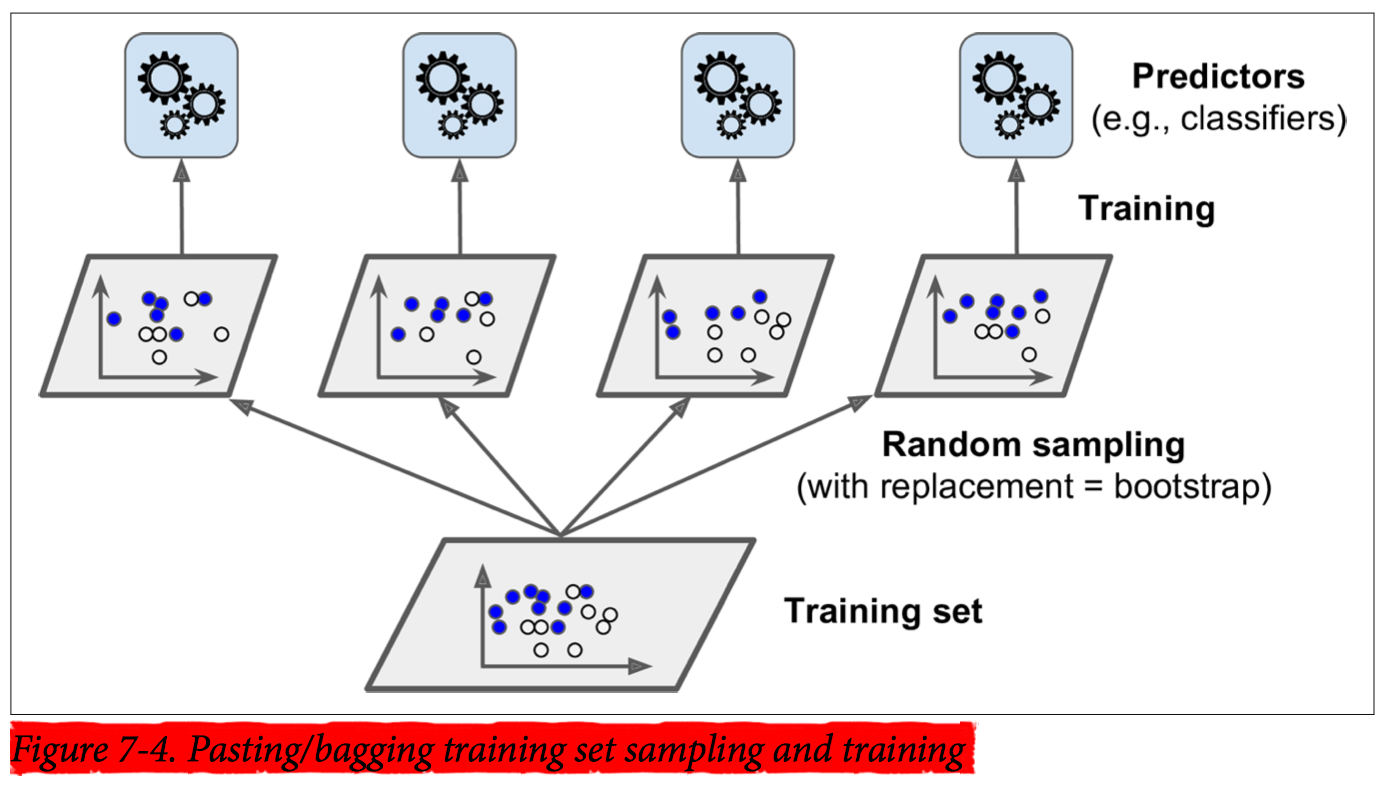

Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors. The aggregation function is typically the statistical mode (i.e., the most frequent prediction, just like a hard voting classifier) for classification, or the average for regression. Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance. Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.

As you can see in `Figure 7-4`, predictors can all be trained in parallel, via different CPU cores or even different servers. Similarly, predictions can be made in parallel. This is one of the reasons why bagging and pasting are such popular methods: they scale very well.


### 7.2.1 Bagging and Pasting in Scikit-Learn
Scikit-Learn offers a simple API for both bagging and pasting with the BaggingClassifier and BaggingRegressor. The following code trains an ensemble of 500 Decision Tree classifiers, each trained on 100 training instances randomly sampled from the training set with replacement (this is an example of bagging, but if you want to use pasting instead, just set bootstrap=False). The `n_jobs` parameter tells Scikit-Learn the number of CPU cores to use for training and predictions (-1 tells Scikit-Learn to use all available cores):

In [4]:
bag_clf = sklearn.ensemble.BaggingClassifier( 
    sklearn.tree.DecisionTreeClassifier(), 
    n_estimators=500, max_samples=100, 
    bootstrap=True, random_state=42, n_jobs=-1) 

bag_clf.fit(X_train, y_train) 
y_pred = bag_clf.predict(X_test)
sklearn.metrics.accuracy_score(y_test, y_pred)

0.90400000000000003

> The BaggingClassifier automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a `predict_proba()` method), which is the case with Decision Trees classifiers.

`Figure 7-5` compares the decision boundary of a single Decision Tree with the decision boundary of a bagging ensemble of 500 trees, both trained on the moons dataset. As you can see, the ensemble’s predictions will likely generalize much better than the single Decision Tree’s predictions: the ensemble has a comparable bias but a smaller variance (it makes roughly the same number of errors on the training set, but the decision boundary is less irregular):

In [5]:
tree_clf = sklearn.tree.DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
sklearn.metrics.accuracy_score(y_test, y_pred_tree)

0.85599999999999998

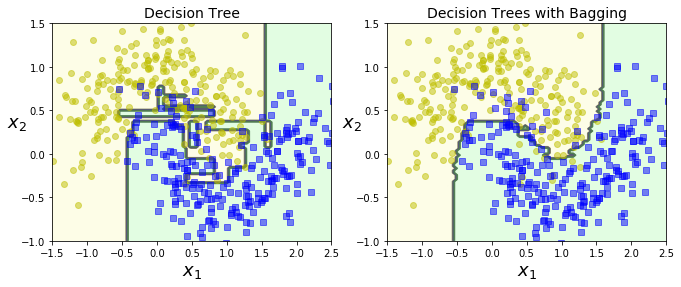

In [6]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = matplotlib.colors.ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = matplotlib.colors.ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

Bootstrapping introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting, but this also means that predictors end up being less correlated so the ensemble’s variance is reduced. Overall, bagging often results in better models, which explains why it is generally preferred. However, if you have spare time and CPU power you can use crossvalidation to evaluate both bagging and pasting and select the one that works best.

### 7.2.2 Out-of-Bag Evaluation
With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. By default a BaggingClassifier samples `m` training instances with replacement ($bootstrap=True$), where `m` is the size of the training set. This means that only about 63% of the training instances are sampled on average for each predictor. The remaining 37% of the training instances that are not sampled are called `out-of-bag` (oob) instances. Note that they are not the same 37% for all predictors.

Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set or cross-validation. You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.

In Scikit-Learn, you can set $oob\_score=True$ when creating a BaggingClassifier to request an automatic oob evaluation after training. The following code demonstrates this. The resulting evaluation score is available through the `oob_score_` variable:

In [11]:
bag_clf = sklearn.ensemble.BaggingClassifier(
    sklearn.tree.DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=42)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.89866666666666661

According to this oob evaluation, this BaggingClassifier is likely to achieve about 89.9% accuracy on the test set. Let’s verify this:

In [12]:
y_pred = bag_clf.predict(X_test)
sklearn.metrics.accuracy_score(y_test, y_pred)

0.91200000000000003

We get 91.2% accuracy on the test set--close enough!

The oob decision function for each training instance is also available through the `oob_decision_function_` variable. In this case (since the base estimator has a `predict_proba()` method) the decision function returns the class probabilities for each training instance. For example, the oob evaluation estimates that the second training instance has a 60.6% probability of belonging to the positive class (and 39.4% of belonging to the positive class):

In [9]:
bag_clf.oob_decision_function_[:5]

array([[ 0.32352941,  0.67647059],
       [ 0.35625   ,  0.64375   ],
       [ 1.        ,  0.        ],
       [ 0.        ,  1.        ],
       [ 0.        ,  1.        ]])

## 7.3 Random Patches and Random Subspaces
The BaggingClassifier class supports sampling the features as well. This is controlled by two hyperparameters: `max_features` and `bootstrap_features`. They work the same way as `max_samples` and `bootstrap`, but for feature sampling instead of instance sampling. Thus, each predictor will be trained on a random subset of the input features.

This is particularly useful when you are dealing with high-dimensional inputs (such as images). Sampling both training instances and features is called the `Random Patches` method. Keeping all training instances (i.e., `bootstrap=False` and `max_samples=1.0`) but sampling features (i.e., `bootstrap_features=True` and/or `max_features` smaller than 1.0) is called the `Random Subspaces` method.

Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.

## 7.4 Random Forests
As we have discussed, a `Random Forest` is an ensemble of Decision Trees, generally trained via the bagging method (or sometimes pasting), typically with `max_samples` set to the size of the training set. Instead of building a `BaggingClassifier` and passing it a `DecisionTreeClassifier`, you can instead use the `RandomForestClassifier` class, which is more convenient and optimized for Decision Trees (similarly, there is a `RandomForestRegressor` class for regression tasks). The following code trains a Random Forest classifier with 500 trees (each limited to maximum 16 nodes), using all available CPU cores:

In [13]:
rnd_clf = sklearn.ensemble.RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

With a few exceptions, a RandomForestClassifier has all the hyperparameters of a DecisionTreeClassifier, plus all the hyperparameters of a BaggingClassifier to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node (see `Chapter 6`), it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following BaggingClassifier is roughly equivalent to the previous RandomForestClassifier:

In [14]:
bag_clf = sklearn.ensemble.BaggingClassifier(
    sklearn.tree.DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [16]:
# almost identical predictions
np.sum(y_pred == y_pred_rf) / len(y_pred)

0.97599999999999998

### 7.4.1 Extra-Trees
When you are growing a tree in a Random Forest, at each node only a random subset of the features is considered for splitting. It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible thresholds (like regular Decision Trees do).

A forest of such extremely random trees is simply called an `Extremely Randomized Trees` ensemble (or `Extra-Trees` for short). Once again, this trades more bias for a lower variance. It also makes `Extra-Trees` much faster to train than regular Random Forests since finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree.

You can create an `Extra-Trees` classifier using Scikit-Learn’s `ExtraTreesClassifier` class. Its API is identical to the `RandomForestClassifier` class. Similarly, the `ExtraTreesRegressor` class has the same API as the `RandomForestRegressor` class.

> It is hard to tell in advance whether a RandomForestClassifier will perform better or worse than an ExtraTreesClassifier. Generally, the only way to know is to try both and compare them using cross-validation (and tuning the hyperparameters using grid search).

### 7.4.2 Feature Importance
Lastly, if you look at a single Decision Tree, important features are likely to appear closer to the root of the tree, while unimportant features will often appear closer to the leaves (or not at all). It is therefore possible to get an estimate of a feature’s importance by computing the average depth at which it appears across all trees in the forest. Scikit-Learn computes this automatically for every feature after training. You can access the result using the `feature_importances_` variable. For example, the following code trains a RandomForestClassifier on the iris dataset (introduced in Chapter 4) and outputs each feature’s importance. It seems that the most important features are the petal length (44%) and width (42%), while sepal length and width are rather unimportant in comparison (11% and 2%, respectively):

In [18]:
iris = sklearn.datasets.load_iris()

rnd_clf = sklearn.ensemble.RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.100973096784
sepal width (cm) 0.0241356704242
petal length (cm) 0.429857930458
petal width (cm) 0.445033302333


Similarly, if you train a Random Forest classifier on the MNIST dataset and plot each pixel’s importance, you get the image represented in `Figure 7-6`:
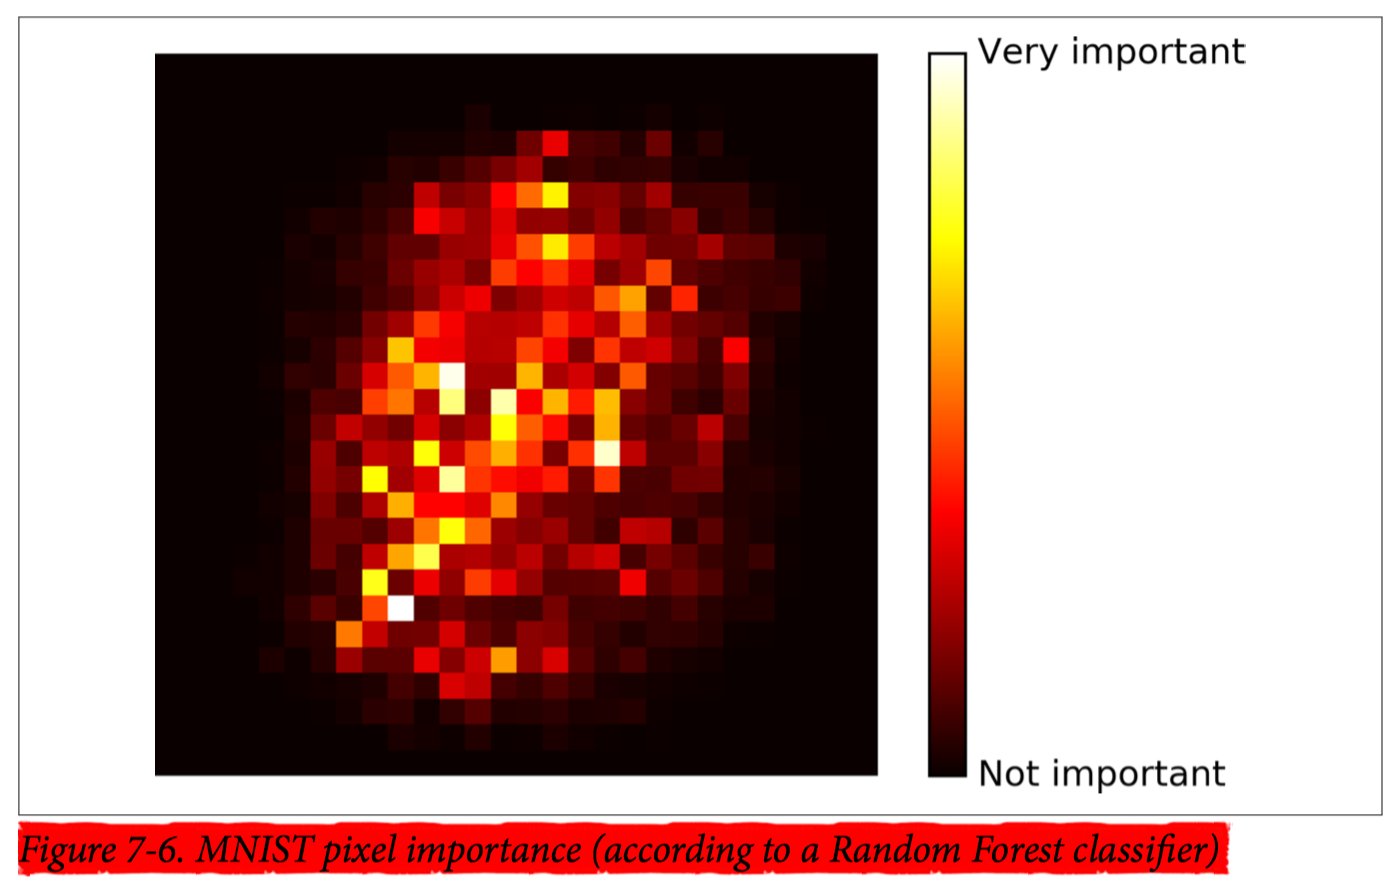

Random Forests are very handy to get a quick understanding of what features actually matter, in particular if you need to perform feature selection.

## 7.5 Boosting
Boosting (originally called hypothesis boosting) refers to any Ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. There are many boosting methods available, but by far the most popular are `AdaBoost` (short for Adaptive Boosting) and `Gradient Boosting`. Let’s start with `AdaBoost`.

### 7.5.1 AdaBoost
One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted. This results in new predictors focusing more and more on the hard cases. This is the technique used by AdaBoost.

For example, to build an AdaBoost classifier, a first base classifier (such as a Decision Tree) is trained and used to make predictions on the training set. The relative weight of misclassified training instances is then increased. A second classifier is trained using the updated weights and again it makes predictions on the training set, weights are updated, and so on (see `Figure 7-7`):
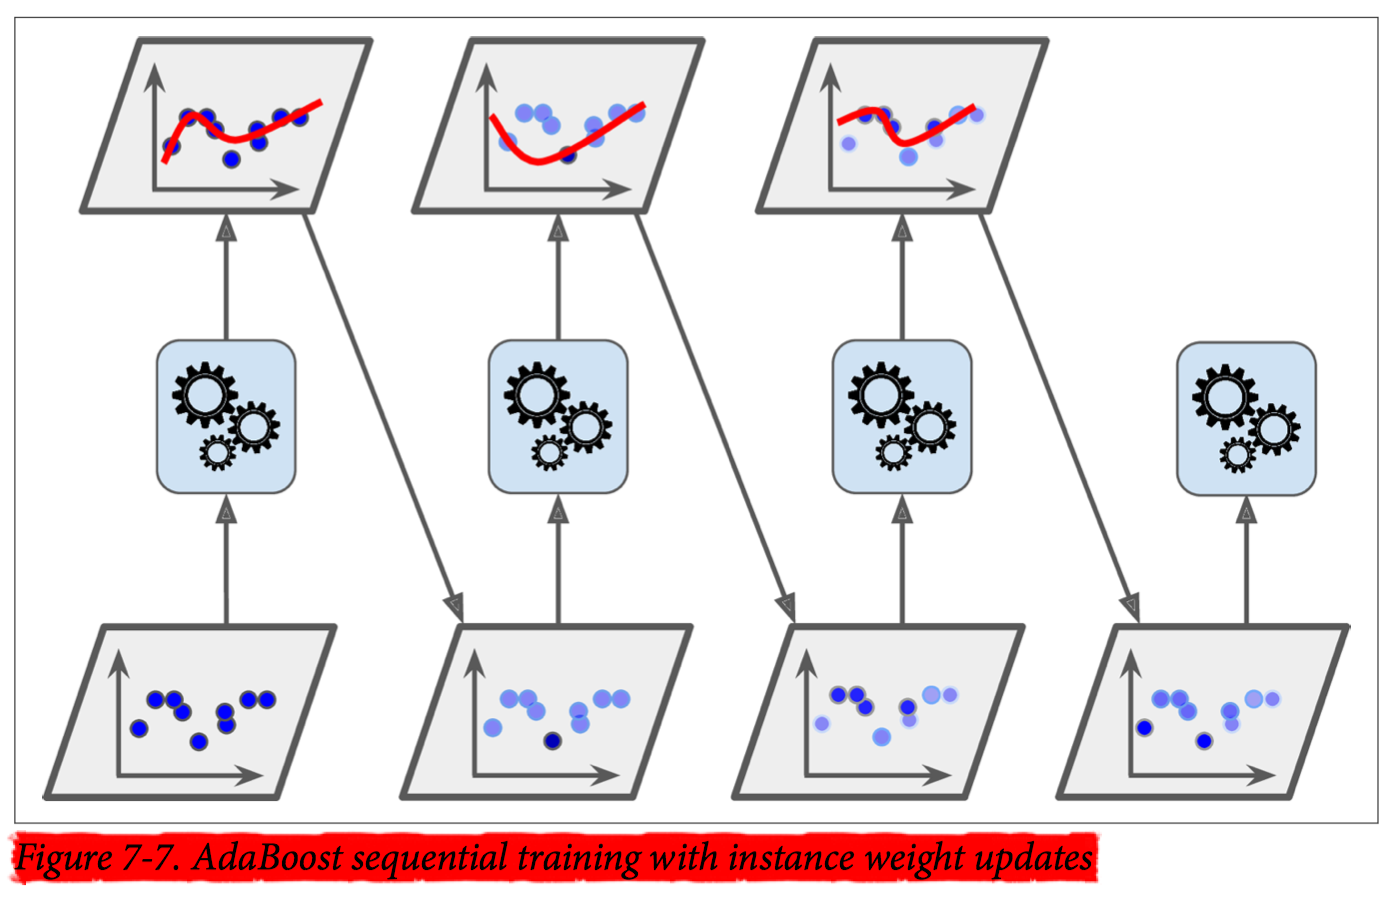

`Figure 7-8` shows the decision boundaries of five consecutive predictors on the moons dataset (in this example, each predictor is a highly regularized SVM classifier with an RBF kernel. *But, this is just for illustrative purposes. SVMs are generally not good base predictors for AdaBoost, because they are slow and tend to be unstable with AdaBoost*). 

The first classifier gets many instances wrong, so their weights get boosted. The second classifier therefore does a better job on these instances, and so on. The plot on the right represents the same sequence of predictors except that the learning rate is halved (i.e., the misclassified instance weights are boosted half as much at every iteration). As you can see, this sequential learning technique has some similarities with `Gradient Descent`, except that instead of tweaking a single predictor’s parameters to minimize a cost function, `AdaBoost` adds predictors to the ensemble, gradually making it better.

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


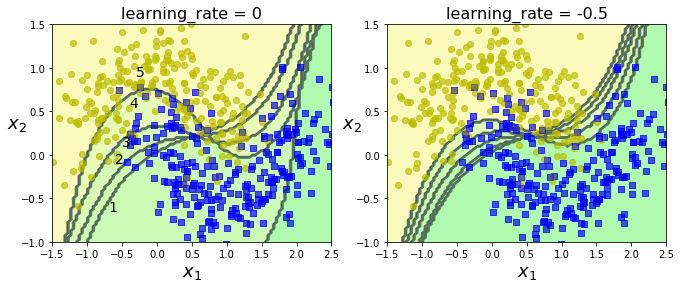

In [21]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    for i in range(5):
        plt.subplot(subplot)
        svm_clf = sklearn.svm.SVC(kernel="rbf", C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate - 1), fontsize=16)

plt.subplot(121)
plt.text(-0.7, -0.65, "1", fontsize=14)
plt.text(-0.6, -0.10, "2", fontsize=14)
plt.text(-0.5,  0.10, "3", fontsize=14)
plt.text(-0.4,  0.55, "4", fontsize=14)
plt.text(-0.3,  0.90, "5", fontsize=14)
plt.show()

Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set.

> There is one important drawback to this sequential learning technique: it cannot be parallelized (or only partially), since each predictor can only be trained after the previous predictor has been trained and evaluated. As a result, it does not scale as well as bagging or pasting.

Let’s take a closer look at the `AdaBoost` algorithm. Each instance weight $w^{(i)}$ is initially set to $\frac{1}{m}$(*上面的示例代码是设置为1，这里有出入*). A first predictor is trained and its weighted error rate $r_1$ is computed on the training set; see `Equation 7-1`:
- $r_j = \frac{\sum_{i=1, \hat{y}_j^{(i)}\ne y_j^{(i)}}^{m}\mathrm{w}^{(i)}}{\sum_{i=1}^{m}\mathrm{w}^{(i)}}$

The predictor’s weight $\alpha_j$ is then computed using `Equation 7-2`, where $\eta$ is the learning rate hyperparameter (defaults to 1). The more accurate the predictor is, the higher its weight will be. If it is just guessing randomly, then its weight will be close to zero. However, if it is most often wrong (i.e., less accurate than random guessing), then its weight will be negative:
- $\alpha_j = \eta log\frac{1-r_j}{r_j}$

Next the instance weights are updated using `Equation 7-3`, the misclassified instances are boosted:
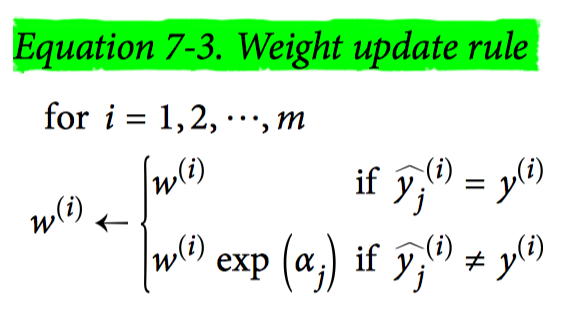

Then all the instance weights are normalized (i.e., divided by $\sum_{i=1}^{m}\mathrm{w}^{(i)}$).

Finally, a new predictor is trained using the updated weights, and the whole process is repeated (the new predictor’s weight is computed, the instance weights are updated, then another predictor is trained, and so on). The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found.

To make predictions, `AdaBoost` simply computes the predictions of all the predictors and weighs them using the predictor weights $\alpha_j$. The predicted class is the one that receives the majority of weighted votes (see `Equation 7-4`):
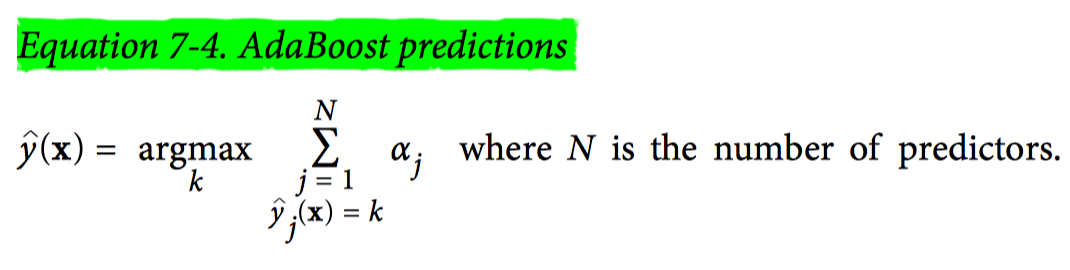

Scikit-Learn actually uses a multiclass version of `AdaBoost` called `SAMME` (Stagewise Additive Modeling using a Multiclass Exponential loss function). When there are just two classes, `SAMME` is equivalent to `AdaBoost`. Moreover, if the predictors can estimate class probabilities (i.e., if they have a `predict_proba()` method), Scikit-Learn can use a variant of `SAMME` called `SAMME.R` (R stands for “Real”), which relies on class probabilities rather than predictions and generally performs better.

The following code trains an `AdaBoost` classifier based on 200 Decision Stumps using Scikit-Learn’s `AdaBoostClassifier` class (as you might expect, there is also an `AdaBoostRegressor` class). A Decision Stump is a Decision Tree with `max_depth=1`--in other words, a tree composed of a single decision node plus two leaf nodes. This is the default base estimator for the `AdaBoostClassifier` class:

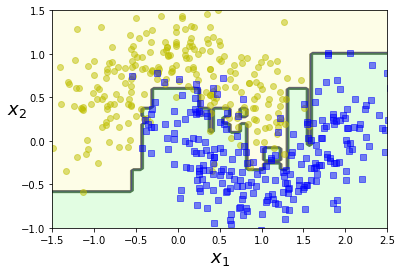

In [22]:
ada_clf = sklearn.ensemble.AdaBoostClassifier(
    sklearn.tree.DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

plot_decision_boundary(ada_clf, X, y)
plt.show()

> If your AdaBoost ensemble is overfitting the training set, you can try reducing the number of estimators or more strongly regularizing the base estimator.

### 7.5.2 Gradient Boosting
Just like `AdaBoost`, `Gradient Boosting` works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like `AdaBoost` does, this method tries to fit the new predictor to the residual errors made by the previous predictor.

Let’s go through a simple regression example using Decision Trees as the base predictors (of course Gradient Boosting also works great with regression tasks). This is called `Gradient Tree Boosting`, or `Gradient Boosted Regression Trees` (GBRT). 

First, let’s fit a DecisionTreeRegressor to the training set (for example, a noisy quadratic training set):

In [24]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

tree_reg1 = sklearn.tree.DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [25]:
# train a second DecisionTreeRegressor on the residual errors made by the first predictor
y2 = y - tree_reg1.predict(X)
tree_reg2 = sklearn.tree.DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [27]:
# train a third regressor on the residual errors made by the second predictor
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = sklearn.tree.DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [28]:
# now we have an ensemble containing three trees
# we can make predictions on a new instance simply by adding up the predictions of all the trees
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([ 0.75026781])

`Figure 7-9` represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column:

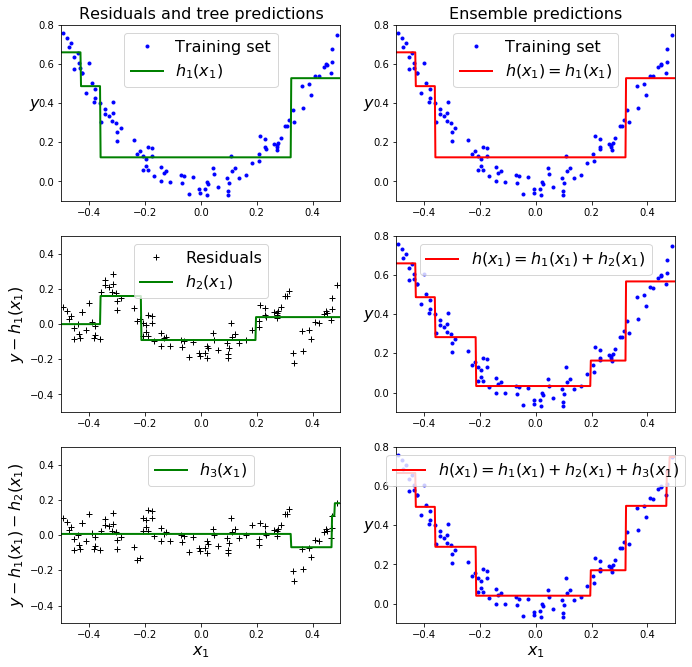

In [32]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", 
                 data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", 
                 data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", 
                 data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], 
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

- in the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions
- in the second row, a new tree is trained on the residual errors of the first tree; on the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees
- in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble

A simpler way to train `GBRT` ensembles is to use Scikit-Learn’s `GradientBoostingRegressor` class. Much like the `RandomForestRegressor` class, it has hyperparameters to control the growth of Decision Trees (e.g., `max_depth`, `min_samples_leaf`, and so on), as well as hyperparameters to control the ensemble training, such as the number of trees (`n_estimators`). The following code creates the same ensemble as the previous one:

In [35]:
gbrt = sklearn.ensemble.GradientBoostingRegressor(max_depth=2, n_estimators=3, 
                                                  learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

The `learning_rate` hyperparameter scales the contribution of each tree. If you set it to a low value, such as 0.1, you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. This is a regularization technique called `shrinkage`. 

`Figure 7-10` shows two `GBRT` ensembles trained with a low learning rate: the one on the left does not have enough trees to fit the training set, while the one on the right has too many trees and overfits the training set:

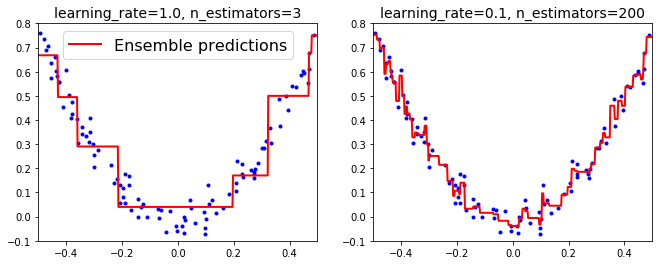

In [36]:
gbrt_slow = sklearn.ensemble.GradientBoostingRegressor(max_depth=2, n_estimators=200, 
                                                       learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.show()

In order to find the optimal number of trees, you can use early stopping (see `Chapter 4`). A simple way to implement this is to use the `staged_predict()` method: it returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees, etc.). The following code trains a `GBRT` ensemble with 120 trees, then measures the validation error at each stage of training to find the optimal number of trees, and finally trains another `GBRT` ensemble using the optimal number of trees:

In [37]:
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y, random_state=49)

gbrt = sklearn.ensemble.GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [sklearn.metrics.mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = sklearn.ensemble.GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=55, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

The validation errors are represented on the left of `Figure 7-11`, and the best model’s predictions are represented on the right:

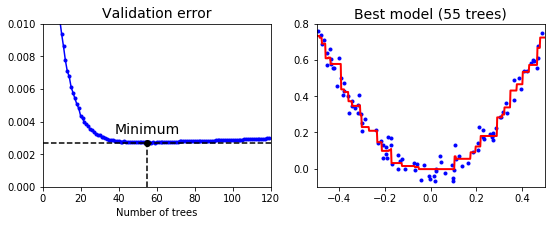

In [42]:
min_error = np.min(errors)

plt.figure(figsize=(9, 3))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.show()

It is also possible to implement early stopping by actually stopping training early (instead of training a large number of trees first and then looking back to find the optimal number). You can do so by setting `warm_start=True`, which makes ScikitLearn keep existing trees when the `fit()` method is called, allowing incremental training. The following code stops training when the validation error does not improve for five iterations in a row:

In [46]:
gbrt = sklearn.ensemble.GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = sklearn.metrics.mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

n_estimators

61

The `GradientBoostingRegressor` class also supports a subsample hyperparameter, which specifies the fraction of training instances to be used for training each tree. For example, if `subsample=0.25`, then each tree is trained on 25% of the training instances, selected randomly. As you can probably guess by now, this trades a higher bias for a lower variance. It also speeds up training considerably. This technique is called `Stochastic Gradient Boosting`.

> It is possible to use Gradient Boosting with other cost functions. This is controlled by the loss hyperparameter (see Scikit-Learn’s documentation for more details).

## 7.6 Stacking
The last Ensemble method we will discuss in this chapter is called `stacking` (short for stacked generalization). It is based on a simple idea: instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, why don’t we train a model to perform this aggregation? `Figure 7-12` shows such an ensemble performing a regression task on a new instance. Each of the bottom three predictors predicts a different value (3.1, 2.7, and 2.9), and then the final predictor (called a blender, or a meta learner) takes these predictions as inputs and makes the final prediction (3.0):
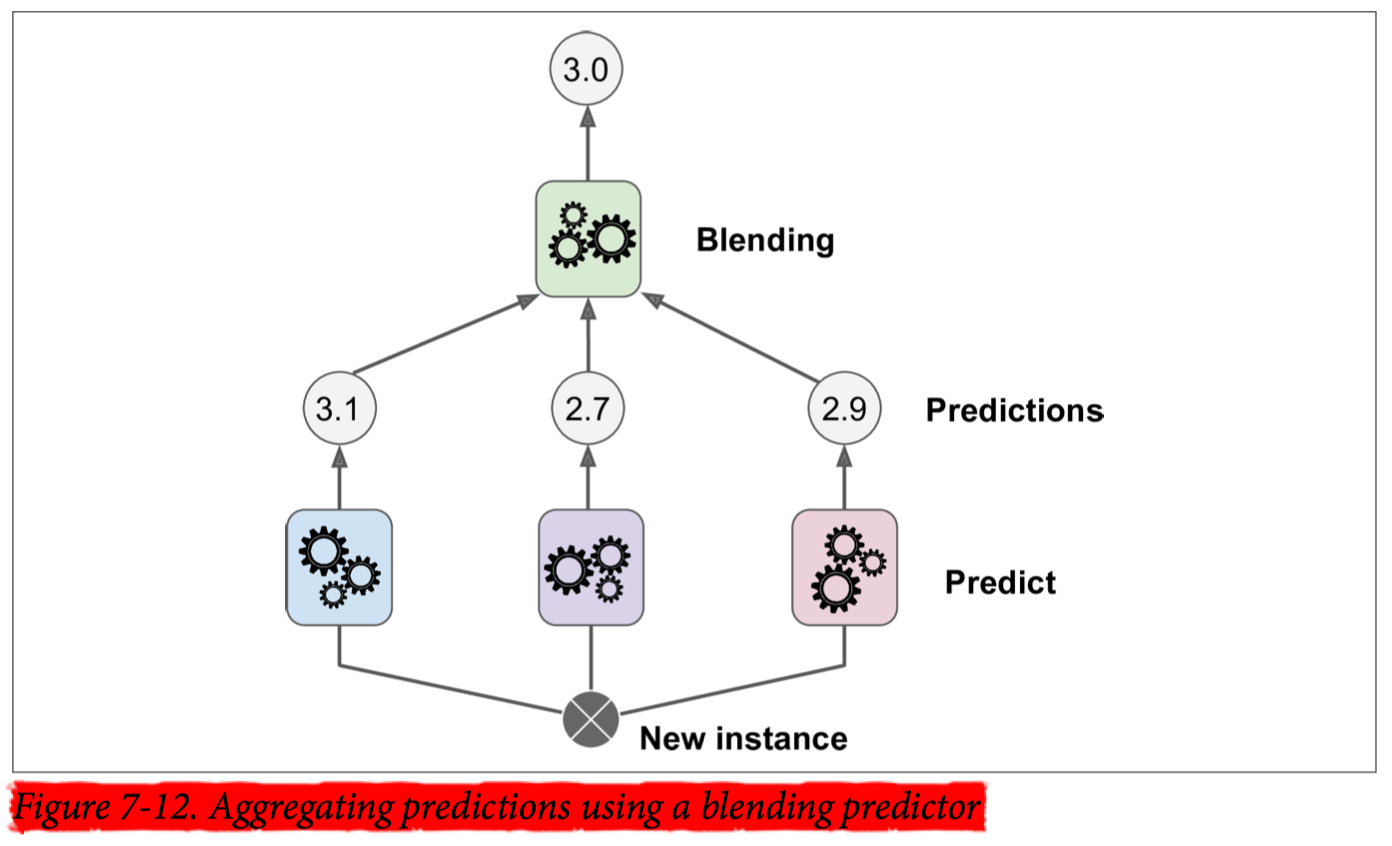

To train the blender, a common approach is to use a hold-out set. Let’s see how it works. First, the training set is split in two subsets. The first subset is used to train the predictors in the first layer (see `Figure 7-13`):
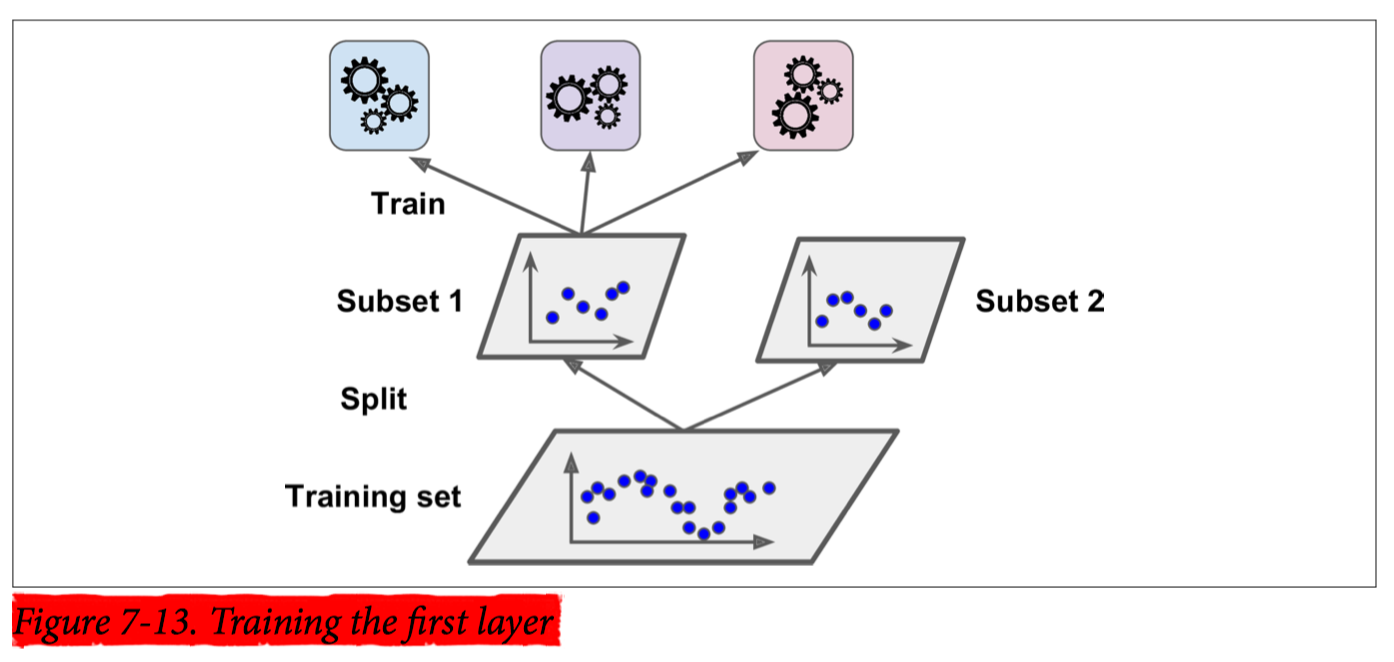

Next, the first layer predictors are used to make predictions on the second (held-out) set (see `Figure 7-14`). This ensures that the predictions are “clean,” since the predictors never saw these instances during training. Now for each instance in the hold-out set there are three predicted values. We can create a new training set using these predicted values as input features (which makes this new training set three-dimensional), and keeping the target values. The blender is trained on this new training set, so it learns to predict the target value given the first layer’s predictions:
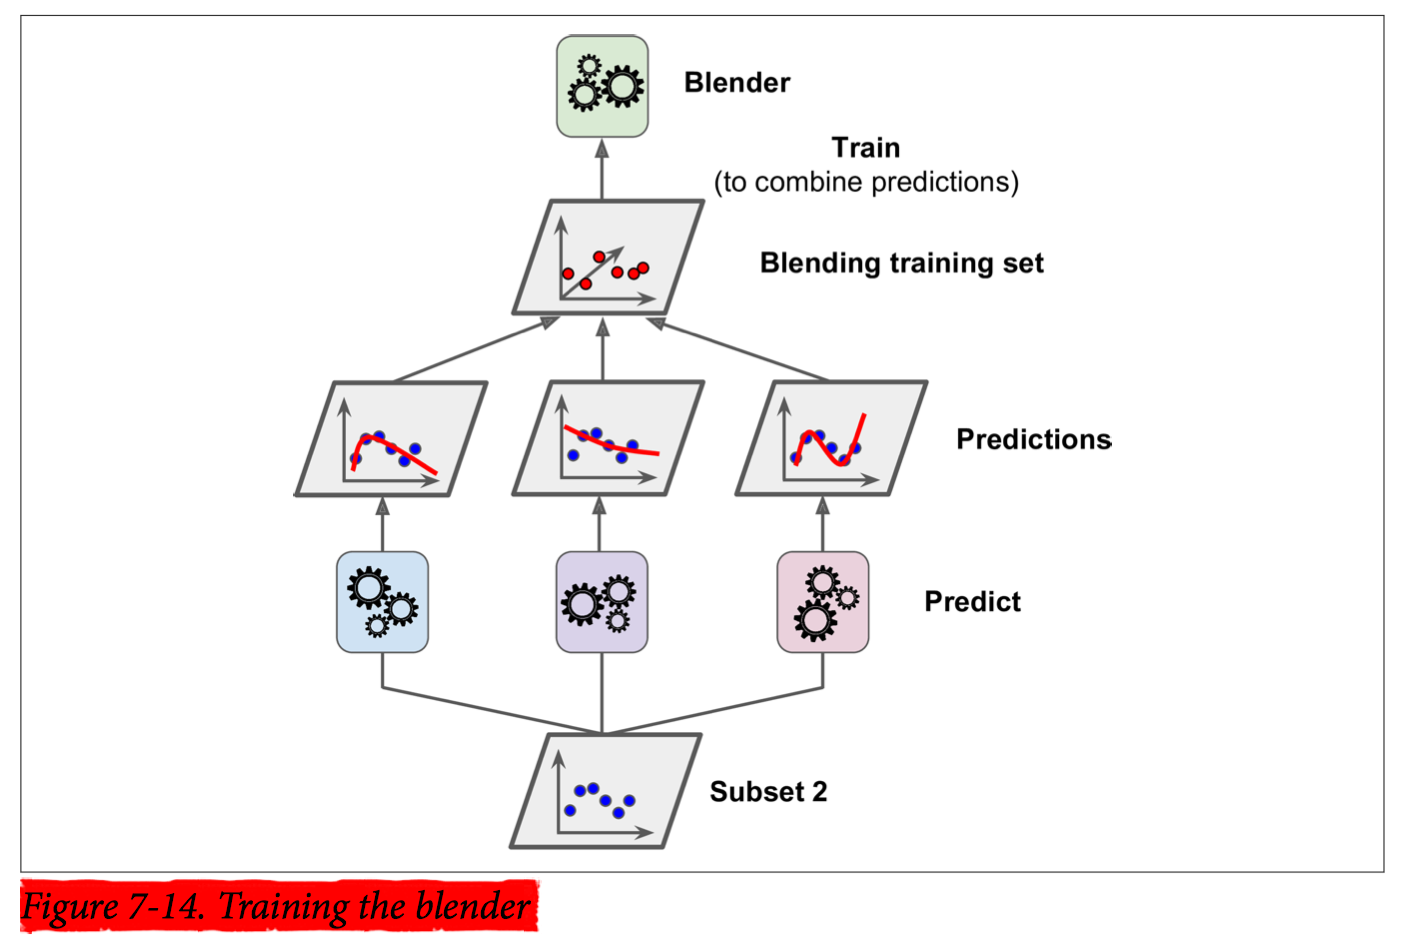

It is actually possible to train several different blenders this way (e.g., one using Linear Regression, another using Random Forest Regression, and so on): we get a whole layer of blenders. The trick is to split the training set into three subsets: the first one is used to train the first layer, the second one is used to create the training set used to train the second layer (using predictions made by the predictors of the first layer), and the third one is used to create the training set to train the third layer (using predictions made by the predictors of the second layer). Once this is done, we can make a prediction for a new instance by going through each layer sequentially, as shown in `Figure 7-15`:
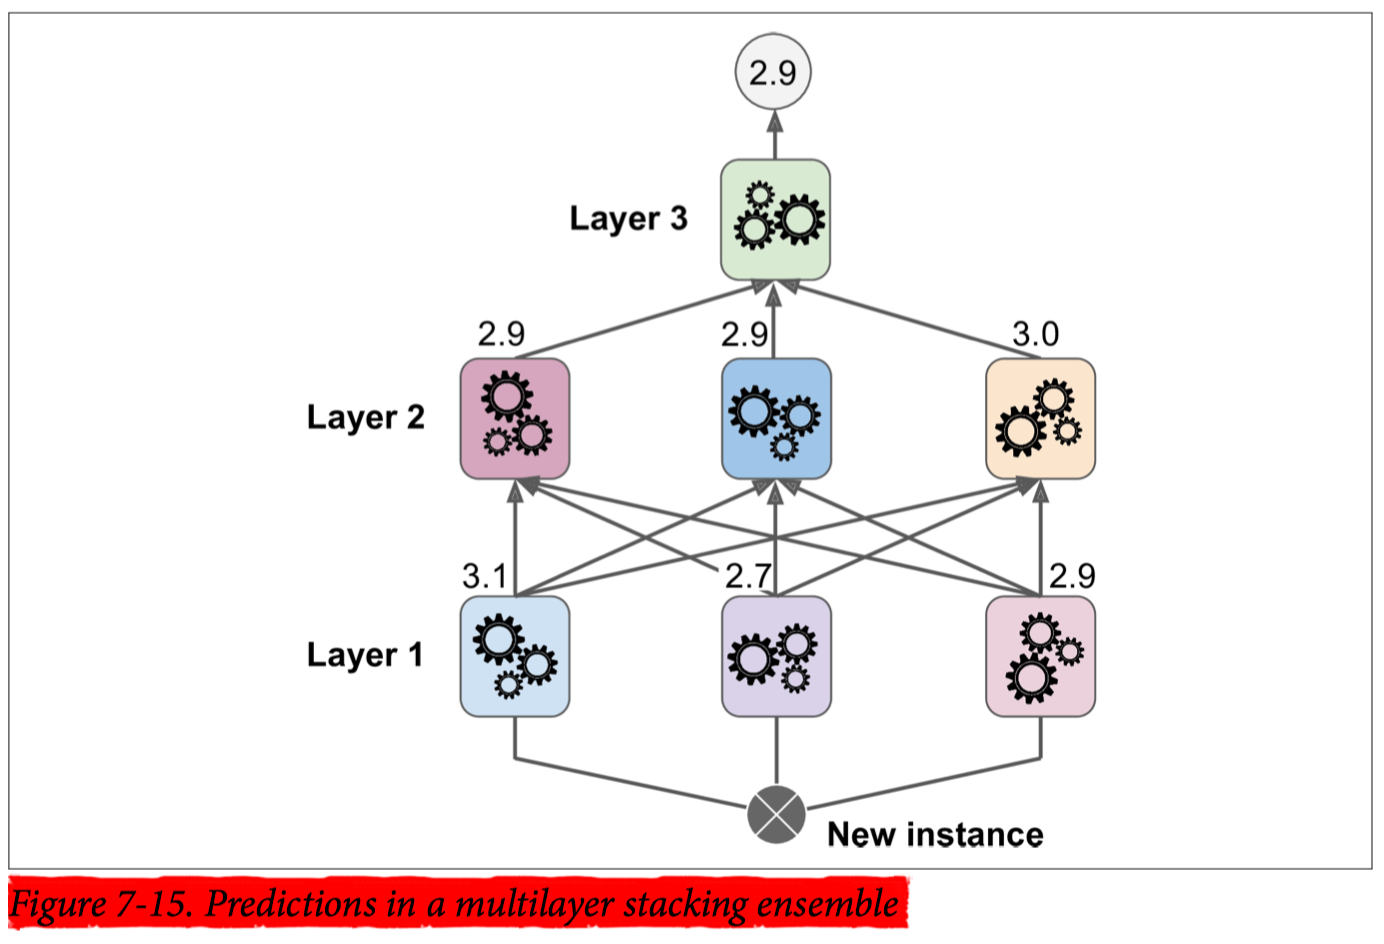

Unfortunately, Scikit-Learn does not support stacking directly, but it is not too hard to roll out your own implementation. Alternatively, you can use [an open source implementation such as brew](https://github.com/viisar/brew).